In [412]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Environment setup
RMOOD_HOME = os.getenv("RMOOD_HOME", "~/RISE/rmood/reward-modeling")

In [413]:
def visualize_pca_with_rewards(reward_model_name, prompt_idx, show_weight=True, align_to_weight=False, num_samples=None, method='pca'):
    """
    특정 prompt에 대한 512개의 representation을 PCA 또는 t-SNE로 2D 축소하고,
    reward 값으로 colormap하여 시각화. Score layer의 weight도 함께 표시.
    
    Args:
        reward_model_name (str): Reward model name (e.g., "Hahmdong/RMOOD-qwen3-4b-alpacafarm-rm")
        prompt_idx (int): Prompt index (e.g., 0, 1, 2, ...)
        show_weight (bool): If True, show the score layer weight vector
        align_to_weight (bool): If True, align first PCA axis to weight direction (only for PCA)
        num_samples (int, optional): Number of samples to visualize. If None, use all samples.
        method (str): Dimensionality reduction method. 'pca' or 'tsne'. Default: 'pca'.
    """
    # Clean model name for file path
    reward_model_name_clean = reward_model_name.replace("/", "_")
    
    # Construct file paths
    representation_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/representation_{prompt_idx}.npy"
    reward_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/reward_{prompt_idx}.json"
    weight_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/weight.npy"
    
    # Check if files exist
    if not os.path.exists(representation_path):
        raise FileNotFoundError(f"Representation file not found: {representation_path}")
    if not os.path.exists(reward_path):
        raise FileNotFoundError(f"Reward file not found: {reward_path}")
    
    # Load representation data
    print(f"Loading representations from: {representation_path}")
    representations = np.load(representation_path)
    print(f"Representation shape: {representations.shape}")
    
    # Load reward data
    print(f"Loading rewards from: {reward_path}")
    with open(reward_path, "r") as f:
        rewards_data = json.load(f)
    rewards = np.array(rewards_data[0])  # Extract the list from the outer array
    print(f"Reward shape: {rewards.shape}")
    
    # Load weight if available and requested
    weight = None
    if show_weight and os.path.exists(weight_path):
        print(f"Loading weight from: {weight_path}")
        weight = np.load(weight_path)
        print(f"Weight shape: {weight.shape}")
        # weight is shape (1, hidden_dim), squeeze to (hidden_dim,)
        weight = weight.squeeze()
    else:
        if show_weight:
            print(f"Warning: Weight file not found at {weight_path}")
    
    # Validate data
    assert len(representations) == len(rewards), f"Mismatch: {len(representations)} representations vs {len(rewards)} rewards"
    
    # Sample if num_samples is specified
    total_samples = len(representations)
    if num_samples is not None and num_samples < total_samples:
        print(f"Sampling {num_samples} out of {total_samples} samples...")
        np.random.seed(42)  # For reproducibility
        sample_indices = np.random.choice(total_samples, size=num_samples, replace=False)
        sample_indices = np.sort(sample_indices)  # Keep order for consistency
        representations = representations[sample_indices]
        rewards = rewards[sample_indices]
        print(f"Sampled representation shape: {representations.shape}")
    else:
        print(f"Using all {total_samples} samples")
    
    # Apply dimensionality reduction to 2D
    if method.lower() == 'tsne':
        print("Applying t-SNE...")
        if align_to_weight:
            print("Warning: align_to_weight is not supported with t-SNE, ignoring...")
        if show_weight:
            print("Warning: Weight direction is not meaningful in t-SNE (non-linear), not displaying...")
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(representations)-1))
        representations_2d = tsne.fit_transform(representations)
        
        # Create a mock object for compatibility
        class MockReducer:
            def __init__(self):
                self.explained_variance_ratio_ = None
                self.components_ = None
        
        reducer = MockReducer()
        
        # For t-SNE, weight direction is not meaningful due to non-linearity
        weight_2d = None
        
    elif method.lower() == 'pca':
        if align_to_weight and weight is not None:
            print("Applying PCA with weight-aligned first axis...")
            
            # Normalize weight to unit vector
            weight_normalized = weight / np.linalg.norm(weight)
            
            # Center the data
            mean_representation = representations.mean(axis=0)
            representations_centered = representations - mean_representation
            
            # Project onto weight direction (first component)
            projections_on_weight = representations_centered @ weight_normalized
            representations_2d_pc1 = projections_on_weight.reshape(-1, 1)
            
            # Compute residuals (orthogonal to weight)
            residuals = representations_centered - np.outer(projections_on_weight, weight_normalized)
            
            # Apply PCA to residuals for second component
            pca_residual = PCA(n_components=1)
            representations_2d_pc2 = pca_residual.fit_transform(residuals)
            
            # Combine into 2D representation
            representations_2d = np.hstack([representations_2d_pc1, representations_2d_pc2])
            
            # Create a custom PCA object for compatibility
            class CustomPCA:
                def __init__(self, components, mean, explained_variance_ratio):
                    self.components_ = components
                    self.mean_ = mean
                    self.explained_variance_ratio_ = explained_variance_ratio
            
            # First component is weight direction, second is from residual PCA
            components = np.vstack([weight_normalized, pca_residual.components_[0]])
            
            # Calculate explained variance ratios
            total_variance = np.var(representations_centered, axis=0).sum()
            variance_pc1 = np.var(projections_on_weight)
            variance_pc2 = pca_residual.explained_variance_[0]
            explained_variance_ratio = np.array([variance_pc1 / total_variance, 
                                                 variance_pc2 / total_variance])
            
            reducer = CustomPCA(components, mean_representation, explained_variance_ratio)
            
        else:
            print("Applying standard PCA...")
            reducer = PCA(n_components=2)
            representations_2d = reducer.fit_transform(representations)
        
        # Transform weight vector to 2D PCA space
        # Note: Use direct projection without centering since weight is a direction vector
        weight_2d = None
        if weight is not None:
            if align_to_weight:
                # When aligned to weight, first axis is exactly the weight direction
                weight_2d = np.array([np.linalg.norm(weight), 0.0])
            else:
                weight_2d = weight @ reducer.components_.T
            print(f"Weight in 2D PCA space: {weight_2d}")
        
        # Print explained variance
        explained_variance = reducer.explained_variance_ratio_
        print(f"Explained variance ratio: PC1={explained_variance[0]:.4f}, PC2={explained_variance[1]:.4f}")
        print(f"Total explained variance: {sum(explained_variance):.4f}")
    
    else:
        raise ValueError(f"Unknown method: {method}. Choose 'pca' or 'tsne'.")
    
    # Create visualization
    plt.figure(figsize=(9, 5))
    
    # Normalize rewards for colormap
    norm = Normalize(vmin=rewards.min(), vmax=rewards.max())
    
    # Scatter plot for representations
    scatter = plt.scatter(
        representations_2d[:, 0], 
        representations_2d[:, 1],
        c=rewards,
        cmap='viridis',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5,
        label='Representations'
    )
    
    # Plot weight vector as arrow from center
    if weight_2d is not None:
        # Compute the center of mass of representations for better visualization
        center = representations_2d.mean(axis=0)
        
        # Scale weight vector for better visualization
        # Scale it to be similar magnitude as the spread of points
        data_scale = np.std(representations_2d, axis=0).mean()
        weight_norm = np.linalg.norm(weight_2d)
        if weight_norm > 0:
            scaled_weight = weight_2d * (data_scale * 2.0) / weight_norm
        else:
            scaled_weight = weight_2d
        
        # Draw arrow from center
        plt.arrow(center[0], center[1], 
                 scaled_weight[0], scaled_weight[1],
                 head_width=data_scale*0.15, 
                 head_length=data_scale*0.2,
                 fc='red', ec='darkred', 
                 linewidth=3, 
                 alpha=0.8,
                 length_includes_head=True,
                 label='Score Weight Direction',
                 zorder=5)
        
        # Mark the center point
        plt.scatter(center[0], center[1], 
                   c='red', s=100, marker='x', 
                   linewidths=3, zorder=6,
                   label='Center of Representations')
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Reward', rotation=270, labelpad=20, fontsize=12)
    
    # Labels and title
    if method.lower() == 'tsne':
        plt.xlabel('t-SNE Dimension 1', fontsize=12)
        plt.ylabel('t-SNE Dimension 2', fontsize=12)
        title = f't-SNE Visualization of Responses (Prompt {prompt_idx})\\nReward Model: {reward_model_name}'
        if weight_2d is not None:
            title += '\\n(Red arrow shows approximated weight direction)'
    elif method.lower() == 'pca':
        if align_to_weight and weight is not None and reducer.explained_variance_ratio_ is not None:
            plt.xlabel(f'Weight Direction ({reducer.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
            plt.ylabel(f'PC2 ({reducer.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
        elif reducer.explained_variance_ratio_ is not None:
            plt.xlabel(f'PC1 ({reducer.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
            plt.ylabel(f'PC2 ({reducer.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
        else:
            plt.xlabel('PC1', fontsize=12)
            plt.ylabel('PC2', fontsize=12)
        
        title = f'PCA Visualization of Responses (Prompt {prompt_idx})\\nReward Model: {reward_model_name}'
        if align_to_weight and weight is not None:
            title += '\\n(First axis aligned to weight direction)'
        elif weight_2d is not None:
            title += '\\n(Red arrow shows score layer weight direction)'
    
    plt.title(title, fontsize=14, pad=20)
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend
    if weight_2d is not None:
        plt.legend(loc='upper right', fontsize=10)
    
    # Add statistics text
    stats_text = f'Total samples: {len(rewards)}\\n'
    stats_text += f'Reward range: [{rewards.min():.3f}, {rewards.max():.3f}]\\n'
    stats_text += f'Mean reward: {rewards.mean():.3f} ± {rewards.std():.3f}'
    if weight is not None:
        stats_text += f'\\nWeight norm: {np.linalg.norm(weight):.3f}'
    plt.text(0.02, 0.98, stats_text, 
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Save figure
    output_dir = f"{RMOOD_HOME}/rmood/distribution/visualization/outputs"
    os.makedirs(output_dir, exist_ok=True)
    
    # Build filename with method and num_samples
    filename = f"{method.lower()}_prompt_{prompt_idx}_{reward_model_name_clean}"
    if num_samples is not None:
        filename += f"_n{num_samples}"
    output_path = f"{output_dir}/{filename}.png"
    
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\\nFigure saved to: {output_path}")
    
    plt.show()
    
    return representations_2d, rewards, reducer, weight_2d

## Example Usage

아래 셀을 실행하여 특정 prompt에 대한 PCA 시각화를 생성할 수 있습니다.
빨간 화살표는 score layer의 weight 방향을 나타냅니다.

Loading representations from: /Users/dongyoonhahm/RISE/rmood/reward-modeling/datasets/alpacafarm/distribution/Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm/representation_10.npy
Representation shape: (512, 2560)
Loading rewards from: /Users/dongyoonhahm/RISE/rmood/reward-modeling/datasets/alpacafarm/distribution/Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm/reward_10.json
Reward shape: (512,)
Loading weight from: /Users/dongyoonhahm/RISE/rmood/reward-modeling/datasets/alpacafarm/distribution/Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm/weight.npy
Weight shape: (1, 2560)
Sampling 128 out of 512 samples...
Sampled representation shape: (128, 2560)
Applying standard PCA...
Weight in 2D PCA space: [0.02979598 0.065514  ]
Explained variance ratio: PC1=0.3658, PC2=0.1441
Total explained variance: 0.5099
\nFigure saved to: /Users/dongyoonhahm/RISE/rmood/reward-modeling/rmood/distribution/visualization/outputs/pca_prompt_10_Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm_n128.png


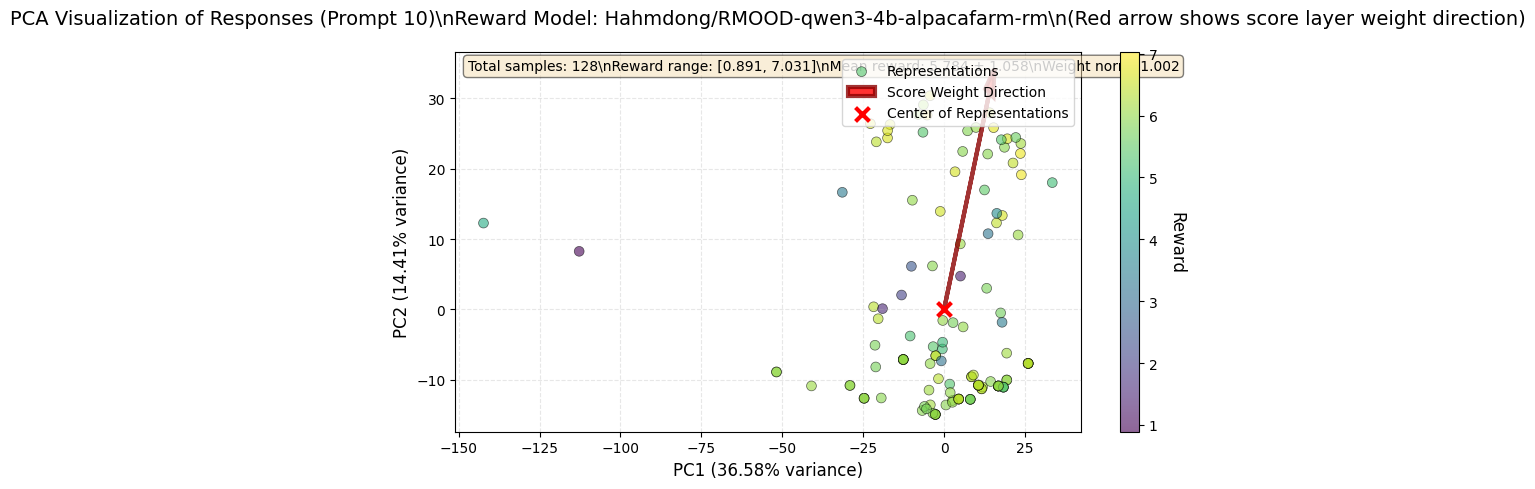

In [414]:
# Example: Visualize prompt index 0 with reward model
reward_model_name = "Hahmdong/RMOOD-qwen3-4b-alpacafarm-rm"
prompt_idx = 10

# Standard PCA visualization
representations_2d, rewards, reducer, weight_2d = visualize_pca_with_rewards(
    reward_model_name, 
    prompt_idx, 
    show_weight=True,
    align_to_weight=False,  # Set to True to align first axis to weight direction (PCA only)
    num_samples=128,  # Set to a number (e.g., 100) to visualize only n samples
    method='pca'  # 'pca' or 'tsne'
)

## 추가 분석: Reward 분포 히스토그램

Figure saved to: /Users/dongyoonhahm/RISE/rmood/reward-modeling/rmood/distribution/visualization/outputs/reward_dist_prompt_10_Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm.png


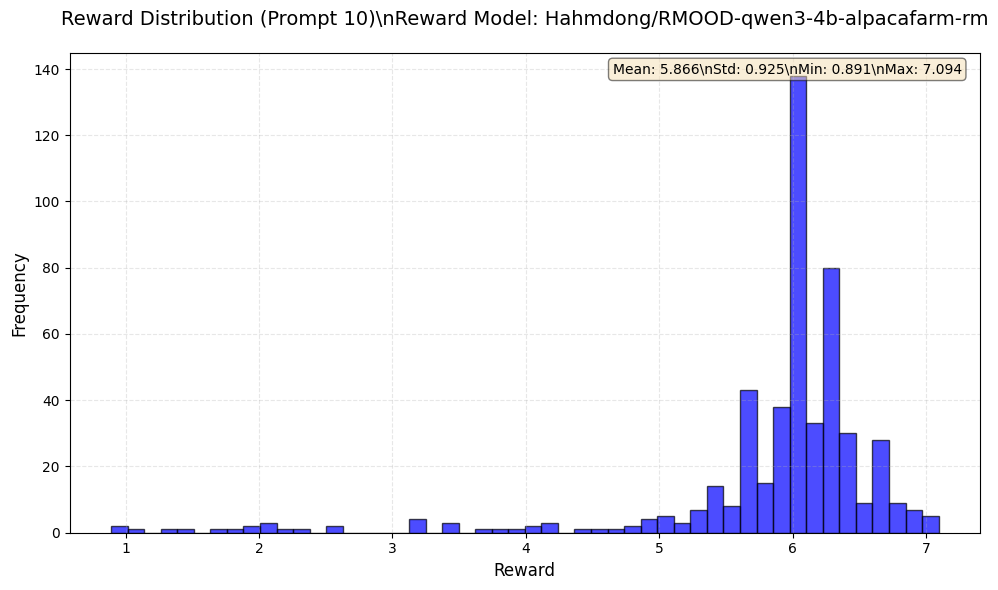

In [ ]:
def plot_reward_distribution(reward_model_name, prompt_idx):
    """
    특정 prompt에 대한 reward 분포를 히스토그램으로 시각화
    """
    reward_model_name_clean = reward_model_name.replace("/", "_")
    reward_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/reward_{prompt_idx}.json"
    
    with open(reward_path, "r") as f:
        rewards_data = json.load(f)
    rewards = np.array(rewards_data[0])
    
    plt.figure(figsize=(10, 6))
    plt.hist(rewards, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Reward', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Reward Distribution (Prompt {prompt_idx})\\nReward Model: {reward_model_name}', 
              fontsize=14, pad=20)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add statistics
    stats_text = f'Mean: {rewards.mean():.3f}\\n'
    stats_text += f'Std: {rewards.std():.3f}\\n'
    stats_text += f'Min: {rewards.min():.3f}\\n'
    stats_text += f'Max: {rewards.max():.3f}'
    plt.text(0.98, 0.98, stats_text, 
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Save figure
    output_dir = f"{RMOOD_HOME}/rmood/distribution/visualization/outputs"
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/reward_dist_prompt_{prompt_idx}_{reward_model_name_clean}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {output_path}")
    
    plt.show()

# Example usage
plot_reward_distribution(reward_model_name, prompt_idx)

## Weight 방향과 Reward의 관계 분석

Score layer의 weight 방향과 실제 reward 값의 상관관계를 분석합니다.

Figure saved to: /Users/dongyoonhahm/RISE/rmood/reward-modeling/rmood/distribution/visualization/outputs/weight_correlation_prompt_10_Hahmdong_RMOOD-qwen3-4b-alpacafarm-rm.png
Correlation coefficient: 0.2010
Mean residual: 3.7258 ± 1.4756


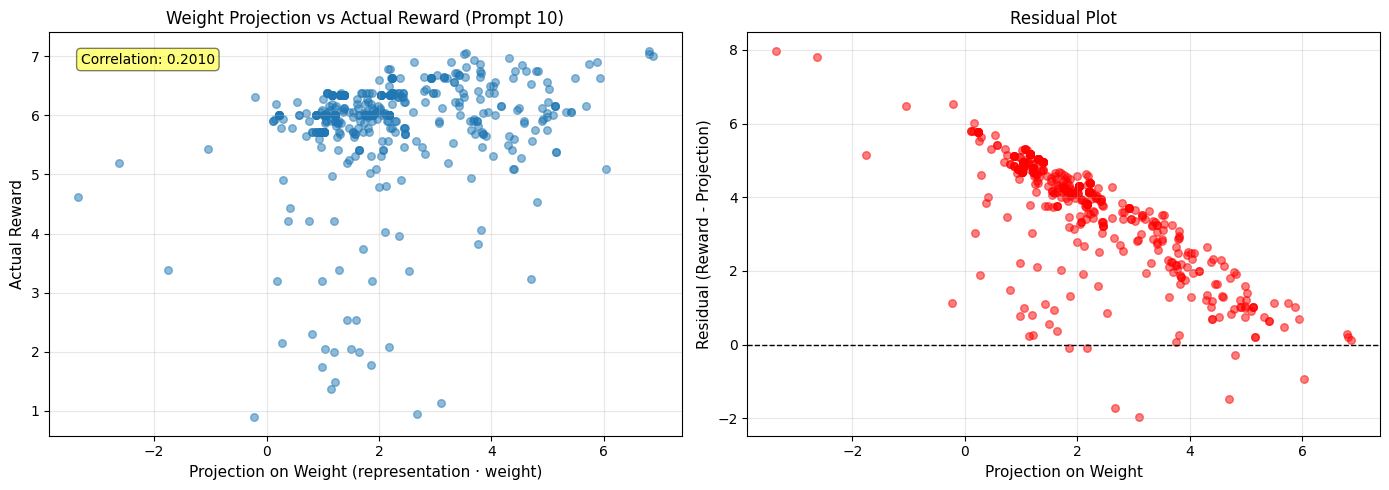

In [416]:
def analyze_weight_correlation(reward_model_name, prompt_idx):
    """
    Weight 방향과 representation의 내적(projection)을 계산하고 실제 reward와 비교
    """
    reward_model_name_clean = reward_model_name.replace("/", "_")
    
    # Load data
    representation_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/representation_{prompt_idx}.npy"
    reward_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/reward_{prompt_idx}.json"
    weight_path = f"{RMOOD_HOME}/datasets/alpacafarm/distribution/{reward_model_name_clean}/weight.npy"
    
    representations = np.load(representation_path)
    with open(reward_path, "r") as f:
        rewards = np.array(json.load(f)[0])
    weight = np.load(weight_path).squeeze()
    
    # Compute projections (inner products)
    projections = representations @ weight
    
    # Plot correlation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Scatter plot
    axes[0].scatter(projections, rewards, alpha=0.5, s=30)
    axes[0].set_xlabel('Projection on Weight (representation · weight)', fontsize=11)
    axes[0].set_ylabel('Actual Reward', fontsize=11)
    axes[0].set_title(f'Weight Projection vs Actual Reward (Prompt {prompt_idx})', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Add correlation coefficient
    correlation = np.corrcoef(projections, rewards)[0, 1]
    axes[0].text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
                transform=axes[0].transAxes,
                fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    # Right: Residual plot
    residuals = rewards - projections
    axes[1].scatter(projections, residuals, alpha=0.5, s=30, color='red')
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1].set_xlabel('Projection on Weight', fontsize=11)
    axes[1].set_ylabel('Residual (Reward - Projection)', fontsize=11)
    axes[1].set_title('Residual Plot', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    output_dir = f"{RMOOD_HOME}/rmood/distribution/visualization/outputs"
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/weight_correlation_prompt_{prompt_idx}_{reward_model_name_clean}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {output_path}")
    print(f"Correlation coefficient: {correlation:.4f}")
    print(f"Mean residual: {residuals.mean():.4f} ± {residuals.std():.4f}")
    
    plt.show()
    
    return projections, correlation

# Example usage
projections, correlation = analyze_weight_correlation(reward_model_name, prompt_idx)

## 설명

### 주요 기능

1. **`visualize_pca_with_rewards()`**: 
   - Representation을 PCA로 2D 축소하고 reward로 colormap
   - Score layer의 weight 벡터를 빨간 화살표로 표시
   - Weight 방향이 높은 reward로 가는 방향을 나타냄

2. **`plot_reward_distribution()`**: 
   - Reward 값들의 분포를 히스토그램으로 시각화

3. **`analyze_weight_correlation()`**: 
   - Weight 방향으로의 projection과 실제 reward의 상관관계 분석
   - 이론적으로는 완벽한 선형 관계여야 하나, 실제로는 bias나 비선형성 등의 영향이 있을 수 있음

### 해석

- **빨간 화살표**: Score layer가 어떤 방향을 선호하는지 표시
- **Color**: Reward 값 (노란색에 가까울수록 높은 reward)
- **화살표 방향의 점들**: 일반적으로 더 높은 reward를 받는 경향